## Deep Learning-Based Classification of Chest X-ray Images: Pneumonia Detection vs Normal Lungs



Rovithi Georgia (5568), Vidalaki Theodosia (5545)


--------------------------------------------------------------------------------------------------------------------------------------------------------

### Introduction


Pneumonia is an inflammatory condition of the lung primarily affecting the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever, and difficulty breathing. The severity of the condition is variable.
Pneumonia is usually caused by infection with viruses or bacteria, and less commonly by other microorganisms. Identifying the responsible pathogen can be difficult. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.

**In this project** we are going to use chest x-ray images for pneumonia diagnosis, using deep learning classification methods. Specifically, we developed a Convolutional Neural Network (CNN) model and used fine-tuning with two different keras tuners. The first one we chose was Random Search, and the second one Bayesian Optimization. We evaluated our results by using multiple different metrics, and came to the conclusion that both of the models perform equally well, with the Random Search tuner being slightly better for screening due to its higher sensitivity, while the Bayesian Optimization tuner offers a more balanced approach, making it more appropriate for final diagnosis.

### Neural Networks
Neural networks are a subset of machine learning, and they are at the heart of deep learning algorithms. They consist of layers of nodes, including an input layer, one or more hidden layers, and an output layer. Each node connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

### Convolutional Neural Networks 

Convolutional Neural Networks (CNNs) are a class of deep learning models particularly effective in processing data that has a grid-like structure—most commonly images.

The core of a CNN consists of several types of layers. First, convolutional layers apply filters that slide over the input image, detecting simple patterns in early layers and more complex structures in deeper ones. Then, pooling layers reduce the spatial size of the data, helping to minimize computation and overfitting by retaining the most significant features. At the end of the network, fully connected layers interpret the features to make predictions or classifications. They are widely used in applications such as facial recognition, autonomous driving, medical imaging (like X-ray analysis), and object detection.

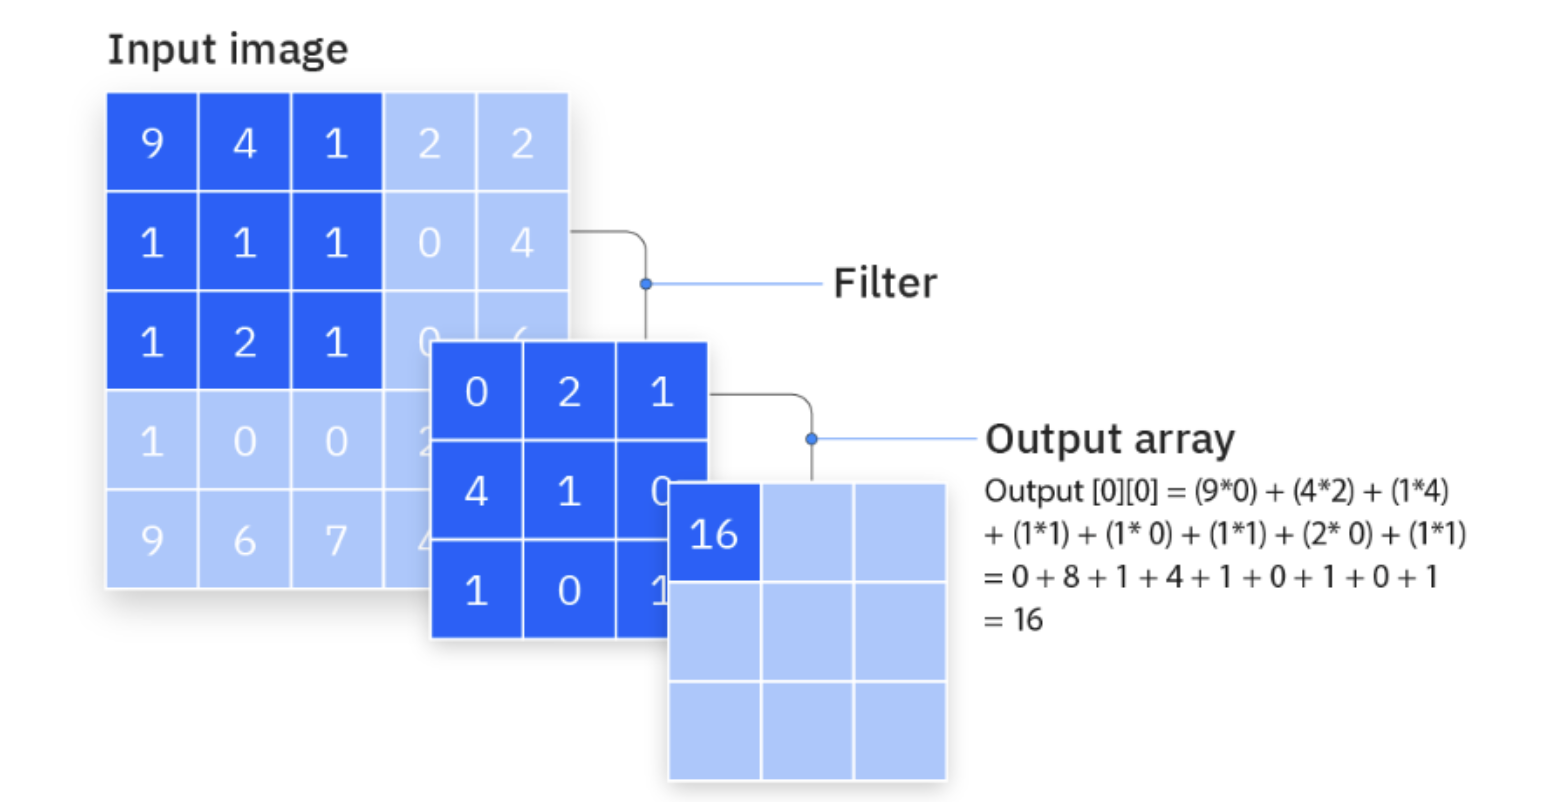


### Random Search Tuner
RandomSearch is the simplest hyperparameter tuner: randomly samples configurations up to a set number of trials, suitable for small-scale or parallelizable tuning tasks, though less efficient than more advanced strategies in larger, complex search spaces.


### Bayesian Optimization Tuner

Bayesian Optimization is an advanced hyperparameter tuning strategy that models the relationship between hyperparameters and the model’s performance. It uses this model (a probabilistic surrogate function, like a Gaussian Process) to predict which hyperparameter values are likely to give better results.
Unlike RandomSearch, which blindly samples, BayesianOptimization uses past trial results to intelligently choose the next set of hyperparameters to try.

### Dataset

The dataset that we used from kaggle contains  5,856 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 

Chest X-ray images were selected from groups of pediatric patients aged one to five years from previously collected clinical records at Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. 
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

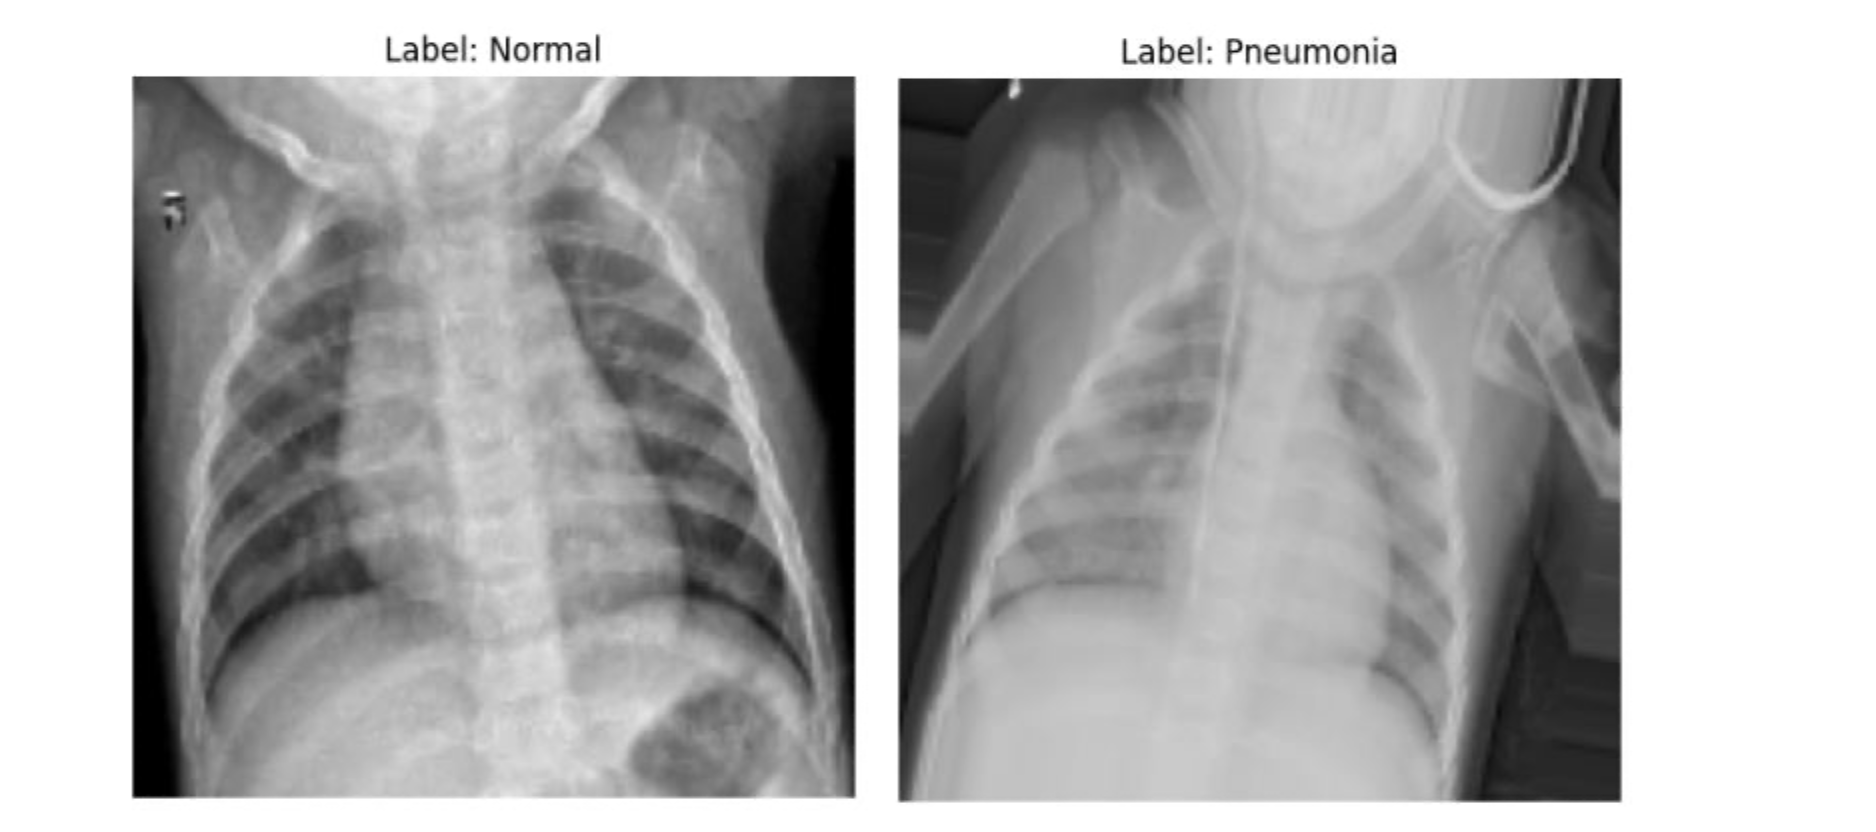

--------------------------------------------------------------------------------------------------------------------------------------------------------

### Libraries

In [32]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")
import kagglehub
from keras.metrics import AUC
import shutil
import random
from tensorflow.keras.models import load_model


### 1. Data preprocessing
The original dataset had 5856 images split into train, validation, test folders by class (NORMAL, PNEUMONIA).
Although the dataset was split into 80% training and 10% testing, the validation set contained only ~16 images, which is too limited to provide a robust assessment of model performance.

To solve this problem we: 
- Merged all images from train, val, test per class into one list
- Randomly shuffled this list (with fixed seed)
- Split images into new train/val/test sets with 80% / 10% / 10% ratio
- Copied images into new folders organized by the new splits and classes

As a result we had balanced dataset splits with enough images in validation set for reliable model evaluation.

In [58]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

dataset_path= '/Users/theodosiavidalaki/Downloads/chest_xray'
new_dataset_path = '/Users/theodosiavidalaki/Downloads/chest_xraydokimas'

# creating files in order to split into subsets (train/val/test) and classes (normal/pneumonia)
for split in ['train', 'val', 'test']:
   for cls in ['NORMAL', 'PNEUMONIA']:
       os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

for cls in ['NORMAL', 'PNEUMONIA']:
   all_files = [] 
   for split in ['train', 'val', 'test']:
       source_folder = f'{dataset_path}/{split}/{cls}'

       files = sorted(os.listdir(source_folder))
       files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

       all_files.extend([(file, source_folder) for file in files])

   
   random.shuffle(all_files)
    
   # splitting the data to 80% train / 10% val / 10% test
   train_files = all_files[:int(len(all_files)*0.8)]
   val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
   test_files = all_files[int(len(all_files)*0.9):]

   # coping the train set images to a new file 
   for file, source_folder in train_files:
       dest = f'{new_dataset_path}/train/{cls}/{file}' # where to copy
       shutil.copy(f'{source_folder}/{file}', dest) #copy

   for file, source_folder in val_files:
       dest = f'{new_dataset_path}/val/{cls}/{file}'
       shutil.copy(f'{source_folder}/{file}', dest)

   for file, source_folder in test_files:
       dest = f'{new_dataset_path}/test/{cls}/{file}'
       shutil.copy(f'{source_folder}/{file}', dest)  

data = []

# looping over every combination (train. val, test)x(NORMAL, PNEUMONIA)
for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(new_dataset_path, split, cls)
        count = len(os.listdir(folder)) #counting how many images on each folder
        data.append({'Split': split, 'Class': cls, 'Images': count})

df = pd.DataFrame(data) # final splitting after data processing
print('Data after preprocessing')
print(df) 

data_old=[]

for cls in ['NORMAL', 'PNEUMONIA']:
    for split in ['train', 'val', 'test']:
        folder1 = f"{dataset_path}/{split}/{cls}"
        count = len(os.listdir(folder1))
        data_old.append({'split': split, 'class': cls, 'count': count})

df1 = pd.DataFrame(data_old) # initial data before processing
print()
print('Data before preprocessing')
print(df1) 

Data after preprocessing
   Split      Class  Images
0  train     NORMAL    1266
1  train  PNEUMONIA    3418
2    val     NORMAL     158
3    val  PNEUMONIA     427
4   test     NORMAL     159
5   test  PNEUMONIA     428

Data before preprocessing
   split      class  count
0  train     NORMAL   1341
1    val     NORMAL      8
2   test     NORMAL    234
3  train  PNEUMONIA   3875
4    val  PNEUMONIA      8
5   test  PNEUMONIA    390


### 2. Visualization of initial and final Data Distributions 

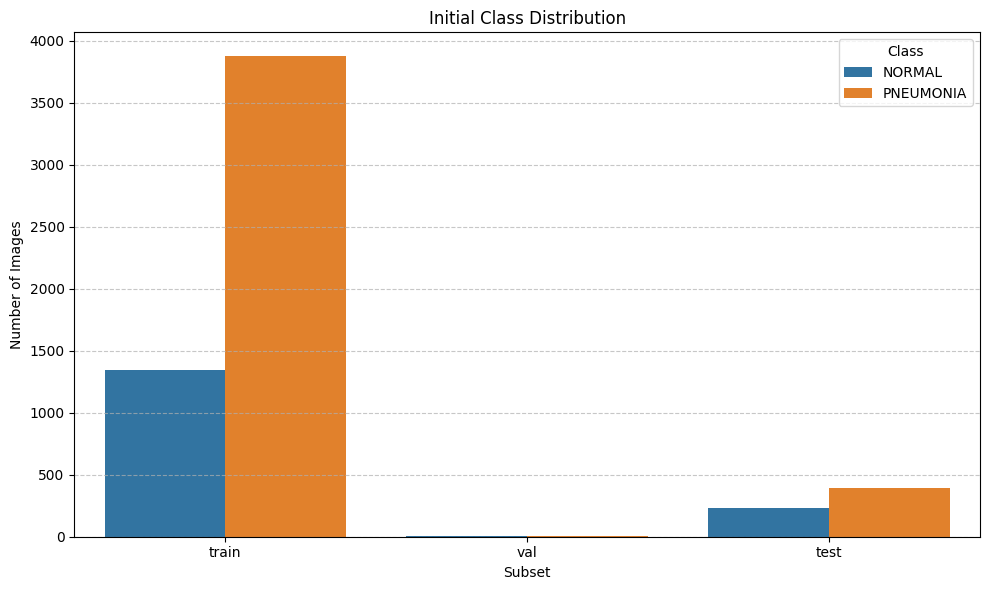

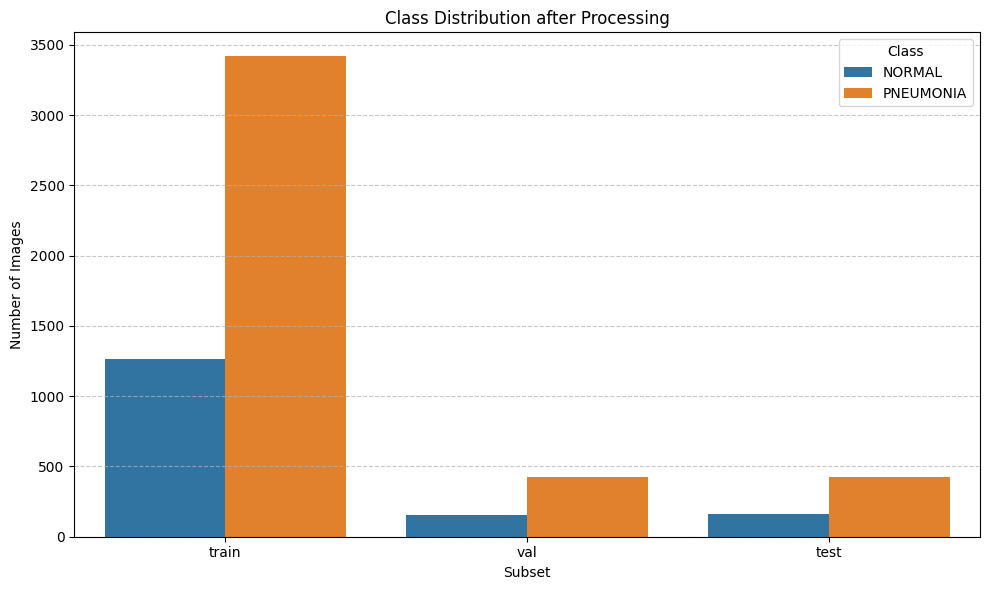

In [61]:
# class / subset distribution 
def plot_class_distribution(base_path,title):
    data = {'Split': [], 'Class': [], 'Count': []}
    
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            # creating a path for each folder of images
            folder = os.path.join(base_path, split, cls)
            
            # image counting
            count = len(os.listdir(folder))
            # adding info to dict
            data['Split'].append(split)
            data['Class'].append(cls)
            data['Count'].append(count)

    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x='Split', y='Count', hue='Class', data=df)
    plt.title(title)
    plt.xlabel("Subset")
    plt.ylabel("Number of Images")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Initial Distribution
plot_class_distribution('/Users/theodosiavidalaki/Downloads/chest_xray', title="Initial Class Distribution")

# Final Distribution
plot_class_distribution('/Users/theodosiavidalaki/Downloads/chest_xraydokimas', title="Class Distribution after Processing")


### 3. Data Generation 

- Setting up image data generators for training, validation, and testing using the reorganized dataset
- Data augmentation for training images, rescale pixel values
- Handling class imbalance by computing class weights
- Creation of generators that load images in batches with specified size and labels for binary classification

It handles imbalance by assigning more importance to the minority class during training. This means the model pays extra attention to the less frequent class to avoid being biased toward the majority class. By doing this, it balances the learning process so that both classes are fairly represented, improving the model’s ability to detect the rarer cases.

In [63]:
if os.path.exists('kt_dir'):
    shutil.rmtree('kt_dir') # delete file kt_dir if it already exists

## GENERATORS to load batches of images and also process them ##

IMG_SIZE = 150 # change images to 150x150 pixels
BATCH_SIZE = 32 # number of pictures taken each time
EPOCHS = 20 # number of training cycles on the whole dataset

base_dir = new_dataset_path # paths for each subset
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# Augmentation techinques for better generalization
train_datagen = ImageDataGenerator(
    rescale=1./255, # normalize pixel values from 0-255 to 0-1 (RGB) / color scaling
    rotation_range=15, # random rotation 15 deg max
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir, # load images from that dir
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True # shuffle at each epoch
)

y_train = train_generator.classes # save labels of training set

#compute class weights to figure out class imbalance - use 'balanced' to balance them
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights)) # dict  to match each class with its weight
print("Class Weights:", class_weights_dict)

# validation set generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # we want shuffling only in the train set to avoid overfitting
                # but to evaluate we need to test/val on the same order
)

# test set generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

num_train = train_generator.samples
num_val = val_generator.samples
num_test = test_generator.samples

total = num_train + num_val + num_test
print()
print(f"Train samples: {num_train}")
print(f"Validation samples: {num_val}")
print(f"Test samples: {num_test}")
print(f"Total samples in dataset: {total}")

from collections import Counter
print()
print("Train class distribution:", Counter(train_generator.classes))
print("Validation class distribution:", Counter(val_generator.classes))
print("Test class distribution:", Counter(test_generator.classes))


Found 4684 images belonging to 2 classes.
Class Weights: {0: 1.8499210110584519, 1: 0.6851960210649503}
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.

Train samples: 4684
Validation samples: 585
Test samples: 587
Total samples in dataset: 5856

Train class distribution: Counter({1: 3418, 0: 1266})
Validation class distribution: Counter({1: 427, 0: 158})
Test class distribution: Counter({1: 428, 0: 159})


### 4. Model
We built a Convolutional Neural Network (CNN) with the Sequential API.

The model:
- Contained 3 convolutional layers, each followed by a max-pooling layer
- Included one fully connected (dense) layer
- Used dropout for regularization
- Ended with an output dense layer for binary classification
- Compiled with the Adam optimizer, binary cross-entropy loss and accuracy as the metric 

Different values are set for the hyperparameters, as the model will undergo fine-tuning to find the optimal configuration.

In [36]:
warnings.filterwarnings('ignore')

# define model for keras tuning

def build_model(hp):
    model = Sequential()
    # min/max value -- of the filter
    # kernel size = filter size 3x3
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ))
    # downsampling
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=64, max_value=128, step=32),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=128, max_value=256, step=64),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten()) # 2D -> 1D to pass it from dense
    
    model.add(Dense(
        units=hp.Int('dense_units', min_value=256, max_value=320, step=64),
        activation='relu'
    ))
    
    # deactivate random percentage of neurons from previous layer on each batch
    # makes the network rely less on specific neurons / avoid overfitting
    
    model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid')) # sigmoid: 0/1
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
        loss='binary_crossentropy', #to measure how close the found probability is to the real labelpes
        metrics=['accuracy'] # binary classification
    )
    return model

### 5. Hyperparameter Tuning and Training with Random Search

We used fine-tuning with Random Search from Keras Tuner to find the best hyperparameters by maximizing validation accuracy.

The tuner ran up to 8 different trials trying different hyperparameter combinations.

For each trial, it:
- Trained the model on the training set and evaluated it on validation, using class weights to handle class imbalance
- Implemented early stopping if validation loss didn’t improve for 3 consecutive epochs

After tuning, it selected the best-performing model based on the accuracy and printed out the best hyperparameter values found.
  
Finally, we trained the best model for up to 30 epochs, with learning rate reduction and early stopping to avoid overfitting.

In [37]:
warnings.filterwarnings('ignore')

# Random Search Tuner
# define tuner
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_accuracy', direction='max'), # maximize accuracy on val set
    max_trials=20, # try 20 different combinations
    executions_per_trial=1, # train 1 time for each trial
    directory='kt_dir', # save tuning results here 
    project_name='pneumonia_tuning',
    seed=42
)
# activate tuner
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict, # patiance - stop if not better after 3 epochs
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps.values)

# final training for the best model
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2), EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
)
# decrease learning rate in half if val loss not better for 2 epochs in a row
# stop training if val loss not better for 4 epochs in a row

Trial 20 Complete [00h 03m 43s]
val_accuracy: 0.9538461565971375

Best val_accuracy So Far: 0.9589743614196777
Total elapsed time: 01h 23m 42s
Best hyperparameters:
{'conv1_filters': 48, 'conv2_filters': 64, 'conv3_filters': 192, 'dense_units': 256, 'dropout_rate': 0.6000000000000001, 'learning_rate': 0.0001715074355925934}
Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.9076 - loss: 0.2255 - val_accuracy: 0.9521 - val_loss: 0.1312 - learning_rate: 1.7151e-04
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.9203 - loss: 0.2030 - val_accuracy: 0.9487 - val_loss: 0.1462 - learning_rate: 1.7151e-04
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.9249 - loss: 0.1819 - val_accuracy: 0.9590 - val_loss: 0.1190 - learning_rate: 1.7151e-04
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 205ms/step - accuracy: 0.9283 - loss: 0.1869 - val_accuracy: 0.9607 - val_loss: 0.1260 - learning_rate: 1.7151e-04
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━

In [39]:
best_model.save("best_pneumonia_model.keras")

### 6. Plots of Accuracy and Loss over Epochs to see Model's Performance During Training


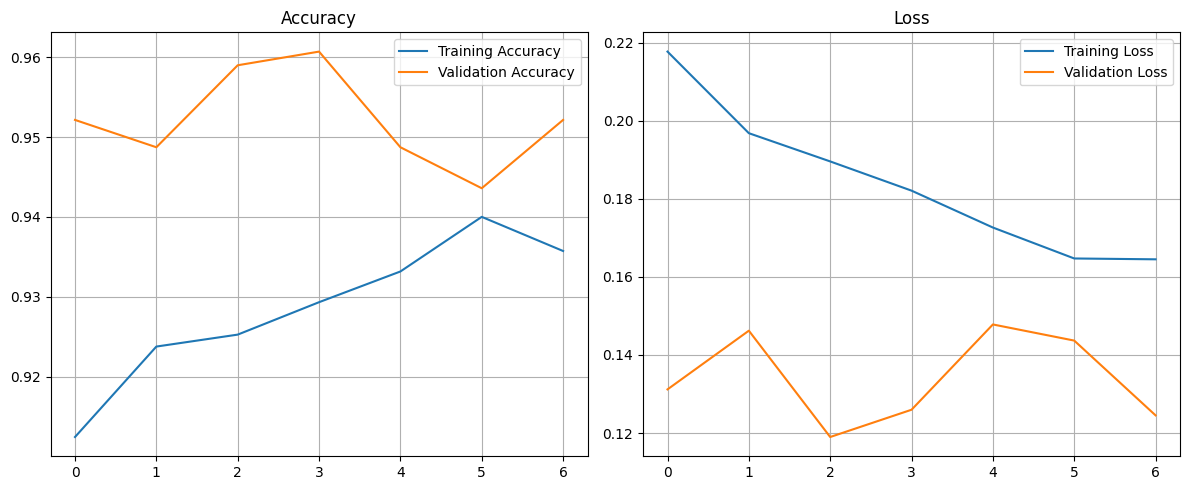

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()

### 7. Evaluation on the test set



In [46]:
print("Running evaluation...")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)
# final evaluation on the test set

Running evaluation...
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9338 - loss: 0.1531


### 8. Optimal Threshold Tuning via F1 Score and Model Evaluation Using Different Metrics

Next, the best-performing model was loaded and used to generate predictions on the test set. 

Threshold tuning was performed by evaluating precision, recall, and F1-score across a range of thresholds (0.1 to 0.9 in steps of 0.01).
The threshold that maximized the F1-score was selected as the optimal decision boundary.

Using this best threshold, the final predicted labels were computed.

***Why f1 score?***


We selected the F1 score as our primary evaluation metric because it is the harmonic mean of precision and recall, effectively balancing the two.

$$
F_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

In the context of medical imaging, such as chest X-rays, both precision (how many predicted pneumonia cases are truly pneumonia) and recall (how many actual pneumonia cases were correctly identified) are critical.

- A low recall means failing to detect true pneumonia cases, which can be dangerous for patient health.
- A low precision means misclassifying healthy individuals as sick, leading to unnecessary diagnostic procedures.

By combining both metrics, the f1 score provides a single, balanced measure of performance, making it particularly appropriate for healthcare-related classification tasks where both false positives and false negatives have serious consequences.

- A detailed classification report was generated, including precision, recall, F1-score, and support for each class.
- A confusion matrix was visualized using a heatmap to illustrate model performance across the two classes: Normal and Pneumonia

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step

BBest Threshold based on F1 Score: 0.32

Classification Report:
               precision    recall  f1-score   support

      Normal       0.93      0.89      0.91       159
   Pneumonia       0.96      0.97      0.97       428

    accuracy                           0.95       587
   macro avg       0.94      0.93      0.94       587
weighted avg       0.95      0.95      0.95       587



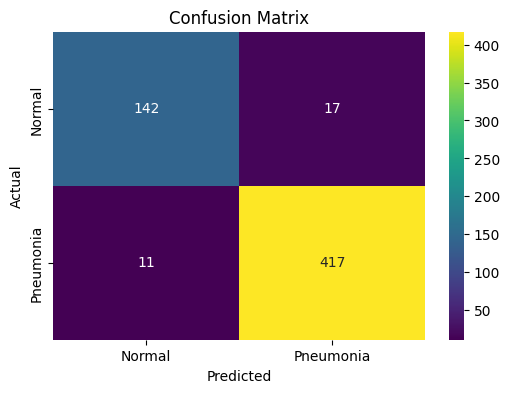

In [47]:
model = load_model("best_pneumonia_model.keras")

# predict with the best model
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

# calculations of precision, recall, f1 for different thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (preds > t).astype(int).reshape(-1) # if pred>threshold-> gives 1 / otherwise 0
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1s.append(f1_score(y_true, y_pred))

# finding the threshold that maximizes f1 score !!!!
best_index = np.argmax(f1s)
best_threshold = thresholds[best_index]
print(f"\nBBest Threshold based on F1 Score: {best_threshold:.2f}")

# threshold we finally use
y_pred = (preds > best_threshold).astype(int).reshape(-1)

# classification report & confusion matrix
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


The **Receiver Operating Characteristic (ROC)** curve was plotted by computing the true positive rate (TPR) against the false positive rate (FPR) at various thresholds.

- The **Area Under the Curve (AUC)** was also calculated, summarizing the model's ability to distinguish between classes.
- A reference line (diagonal) was added to indicate random performance.

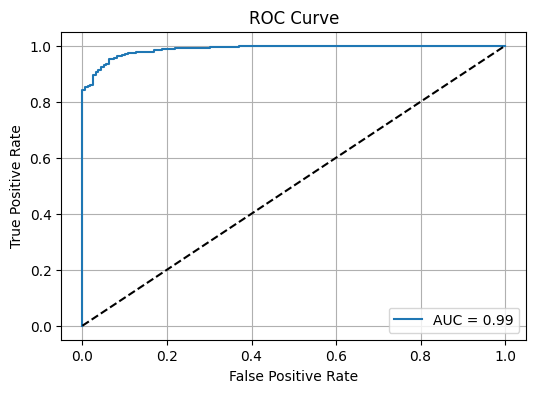

In [48]:
# ROC Curve

# fpr - false positive rate = FP / (FP+TN)
# tpr - true positive rate = TP / (TP+FN) = recall

fpr, tpr, roc_thresholds = roc_curve(y_true, preds)
roc_auc = roc_auc_score(y_true, preds)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

**Precision / Recall / F1 Score vs. Threshold plot shows how each metric varies as the classification threshold changes.**

A vertical dashed line indicates the best threshold - the one that maximizes the f1 score.

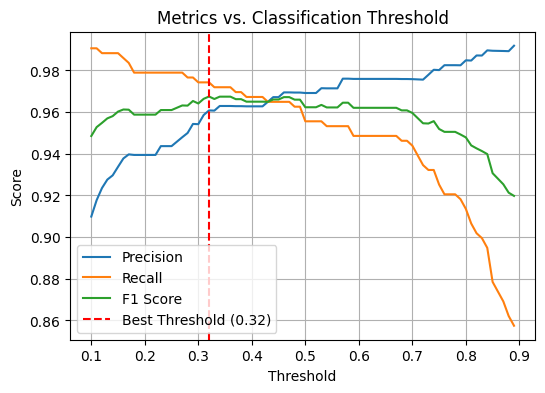

In [49]:
# Precision/Recall/F1 vs Threshold graph

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

### 9. Hyperparameter Tuning and Training with Bayesian Optimization
We applied fine-tuning using Bayesian Optimization from Keras Tuner to find the best hyperparameters by maximizing validation accuracy.

The tuner conducted up to 8 trials, exploring different hyperparameter combinations guided by a probabilistic model.

For each trial, it:
- Trained the model on the training set and evaluated on the validation set, using class weights to address class imbalance.
- Used early stopping if the validation loss did not improve for 3 consecutive epochs.

After tuning, the best-performing model was selected based on validation accuracy, and the best hyperparameter values were printed.

Finally, we trained the selected model for up to 30 epochs, using learning rate reduction on plateau and early stopping to prevent overfitting.

In [50]:
warnings.filterwarnings('ignore')
# keras fine-tuning with Bayesian Optimization

tuner1 = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy',direction='max'),
    max_trials=20, 
    executions_per_trial=1,
    directory='kt_dir_bayes',
    project_name='pneumonia_bayes_tuning'
)

# finding the optimal hyperparameter values
tuner1.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# getting the best model and the best hyperparameters
best_model1 = tuner1.get_best_models(num_models=1)[0]
best_hps1 = tuner1.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps1.values)

# training the best model
history1 = best_model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]

)

Trial 20 Complete [00h 04m 50s]
val_accuracy: 0.952136754989624

Best val_accuracy So Far: 0.9874085187911987
Total elapsed time: 1d 15h 41m 47s
Best hyperparameters:
{'conv1_filters': 16, 'conv2_filters': 128, 'conv3_filters': 256, 'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0003610323940298591}
Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - accuracy: 0.9231 - loss: 0.2073 - val_accuracy: 0.9521 - val_loss: 0.1272 - learning_rate: 3.6103e-04
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - accuracy: 0.9270 - loss: 0.1894 - val_accuracy: 0.9299 - val_loss: 0.1892 - learning_rate: 3.6103e-04
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9166 - loss: 0.1987 - val_accuracy: 0.9607 - val_loss: 0.1321 - learning_rate: 3.6103e-04
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 36s 242ms/step - accuracy: 0.9352 - loss: 0.1726 - val_accuracy: 0.9487 - val_loss: 0.1289 - learning_rate: 1.8052e-04
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 36s 246ms/

In [51]:
best_model1.save("best_pneumonia_model1.keras")

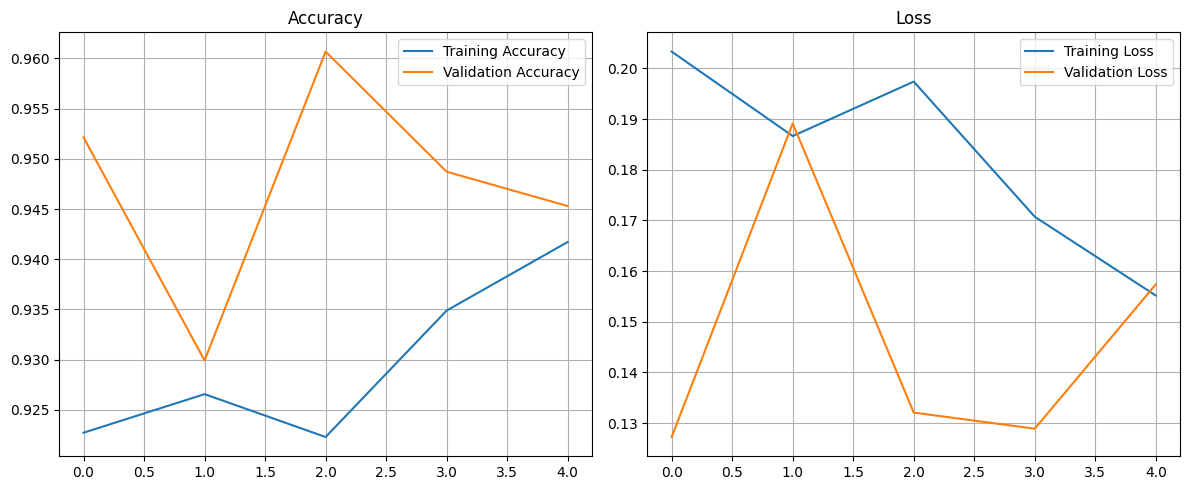

In [52]:
#accuracy and loss plots over epochs
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs_range1 = range(len(acc1))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range1, acc1, label='Training Accuracy')
plt.plot(epochs_range1, val_acc1, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range1, loss1, label='Training Loss')
plt.plot(epochs_range1, val_loss1, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step

BBest Threshold based on F1 Score: 0.38

Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.90      0.90       159
   Pneumonia       0.96      0.96      0.96       428

    accuracy                           0.95       587
   macro avg       0.93      0.93      0.93       587
weighted avg       0.95      0.95      0.95       587



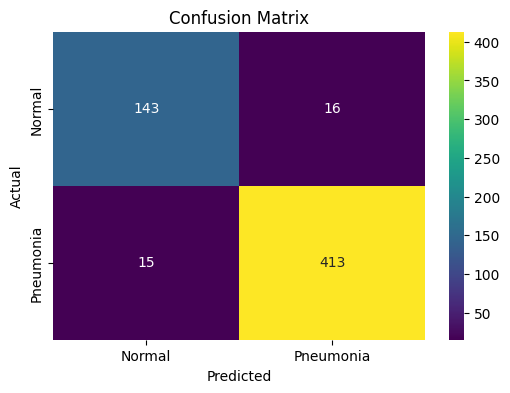

In [53]:
model1 = load_model("best_pneumonia_model1.keras")

# predict with the best model
test_generator.reset()
preds1 = model1.predict(test_generator, verbose=1)
y_true1 = test_generator.classes

# calculations of precision, recall, f1 for different thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred1 = (preds1 > t).astype(int).reshape(-1)
    precisions.append(precision_score(y_true1, y_pred1))
    recalls.append(recall_score(y_true1, y_pred1))
    f1s.append(f1_score(y_true1, y_pred1))

# finding the threshold that maximizes f1 score
best_index = np.argmax(f1s)
best_threshold = thresholds[best_index]
print(f"\nBBest Threshold based on F1 Score: {best_threshold:.2f}")

# threshold we finally use
y_pred1 = (preds1 > best_threshold).astype(int).reshape(-1)

# classification report & confusion matrix
print("\nClassification Report:\n", classification_report(y_true1, y_pred1, target_names=["Normal", "Pneumonia"]))

cm = confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


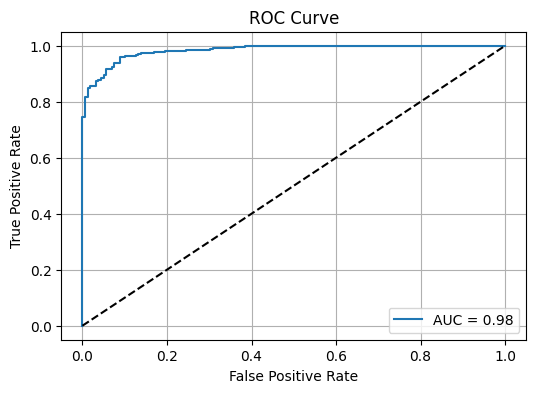

In [55]:
# ROC Curve

fpr, tpr, roc_thresholds = roc_curve(y_true1, preds1)
roc_auc = roc_auc_score(y_true1, preds1)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

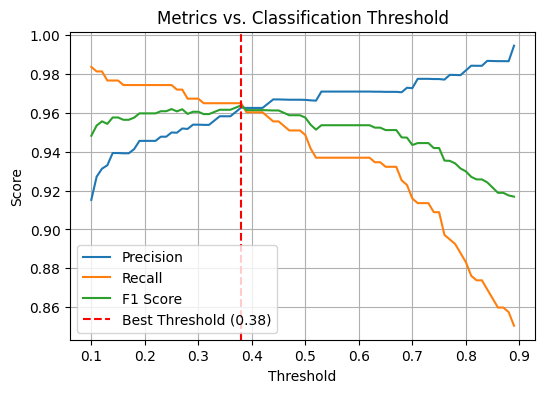

In [56]:
# Precision/Recall/F1 vs Threshold plot

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
print("Running evaluation...")
test_loss, test_accuracy = best_model1.evaluate(test_generator, verbose=1)

Running evaluation...
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9237 - loss: 0.1838


### 10. Conclusions
According to the above analysis, we observe that both of the tuners perform equally well in terms of overall accuracy and F1-score, but they exhibit different characteristics in their behavior. 

The model obtained through Random Search, which operates with a lower decision threshold, demonstrates higher sensitivity, making it more effective at identifying cases of pneumonia. On the other hand, the model from Bayesian Optimization, with its higher threshold, appears to be more balanced between classes, though slightly more prone to false negative predictions.

If the goal is to build a screening tool — one that prioritizes not missing any potential pneumonia cases, even at the cost of more false alarms — then the first model (Random Search) appears to be more appropriate due to its greater sensitivity.

However, if the model is intended to serve as a final diagnostic aid, where precision and overall balance are more critical to avoid unnecessary treatment or further tests, then the second model (Bayesian Optimization) may be more suitable.

#### References
1. https://en.wikipedia.org/wiki/Pneumonia
2. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data
3. https://www.ibm.com/think/topics/convolutional-neural-networks
4. https://www.tensorflow.org/tutorials/keras/keras_tuner

And also we would like to give special thanks to our favorite AI - ChatGPT- for helping us (mainly) with generating this very realistic image of Theodosia's laptop condition after this project.

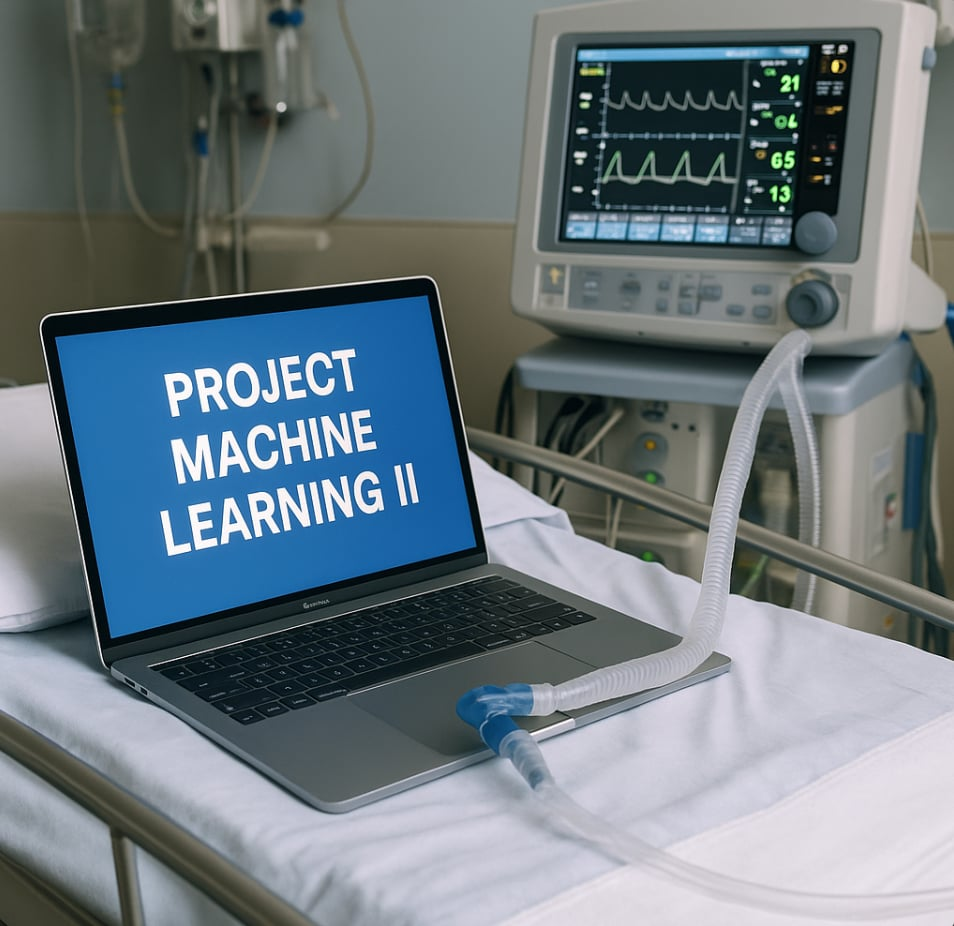

---------------------------------------------------------------------------------------------------------------------------------------------------------